## Import

In [1]:
from pathlib import Path
import random
import glob

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

pd.set_option('max_colwidth', None)

In [7]:
cd /home/sanjyot/latcom

/home/sanjyot/latcom


In [125]:
from preprocess import preprocess_labels, preprocess_image
from transform import construct_dataset
from models import load_nvidia

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
data_dir = Path('.').resolve() / 'dataset' / 'udacity_simulator' / 'tracks'
label_path = data_dir / 'driving_log.csv'

In [11]:
img_dir = data_dir / 'IMG'
img_count = len(list(img_dir.glob('*')))

lbl = pd.read_csv(
    label_path, 
    names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
)

print(f'Total images: {img_count}')
print(f'Total records: {len(lbl)}')

Total images: 97329
Total records: 32443


## Preprocess labels

In [122]:
downsample_ratio = 0.8  # Controls how much percentage of straight driving labels are discarded

lbl_fix = preprocess_labels(lbl, downsample_ratio)


Original size: 32443 | New size: 16073
Size reduced to 49.54%


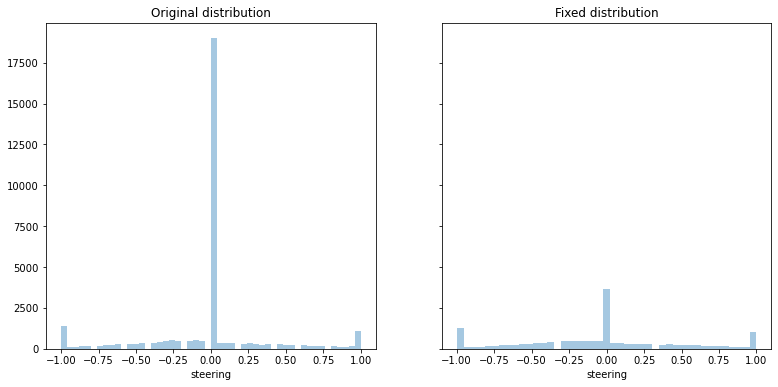

In [123]:
# Plot distribution change

fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
sns.distplot(lbl['steering'], ax=ax[0], kde=False)
sns.distplot(lbl_fix['steering'], ax=ax[1], kde=False)
ax[0].set_title('Original distribution')
ax[1].set_title('Fixed distribution')
_ = plt.plot()

## Preprocess images

(160, 320, 3)


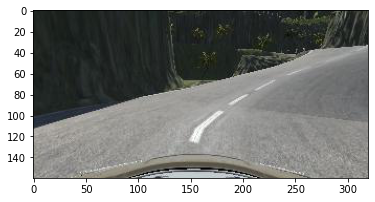

In [14]:
# Show sample image

index = 150
image_dir = data_dir / 'IMG'
sample_image_path = glob.glob(f'{str(image_dir)}/center*.jpg')[index]

img = cv.imread(sample_image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print(img.shape)
_ = plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


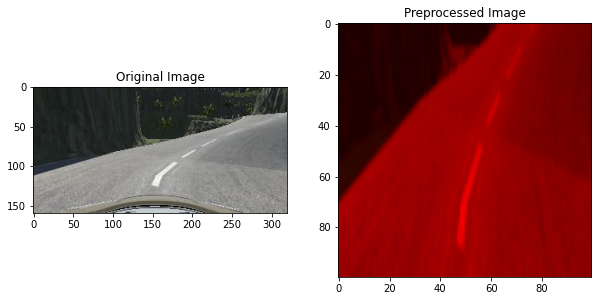

In [119]:
# Plot preprocessing result

original_image = cv.cvtColor(cv.imread(str(sample_image_path)), 
                             cv.COLOR_BGR2RGB)
preprocessed_image = preprocess_image(sample_image_path).numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
_ = plt.plot()

## Prepare training data

In [124]:
lbl_fix.head()

,center,left,right,steering,throttle,reverse,speed
20816,center_2019_04_02_18_17_31_186.jpg,left_2019_04_02_18_17_31_186.jpg,right_2019_04_02_18_17_31_186.jpg,0.00,0.000000,0.0,8.840526
7479,center_2019_04_02_19_34_28_626.jpg,left_2019_04_02_19_34_28_626.jpg,right_2019_04_02_19_34_28_626.jpg,-0.15,0.163009,0.0,13.826410
13406,center_2019_04_02_18_08_52_681.jpg,left_2019_04_02_18_08_52_681.jpg,right_2019_04_02_18_08_52_681.jpg,0.05,1.000000,0.0,8.236159
32071,center_2019_04_02_18_30_38_650.jpg,left_2019_04_02_18_30_38_650.jpg,right_2019_04_02_18_30_38_650.jpg,-0.35,0.168453,0.0,9.012923
243,center_2019_04_02_19_25_50_916.jpg,left_2019_04_02_19_25_50_916.jpg,right_2019_04_02_19_25_50_916.jpg,0.00,0.000000,0.0,11.861010


In [128]:
train, valid = construct_dataset(lbl_fix, data_dir, batch_size=128, validation_split_ratio=0.2)
print(f'\nData tensor spec:\n{train.element_spec}')

Training samples: 12859
Validation samples: 3214

Data tensor spec:
(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))


## NVIDIA model

In [116]:
nvidia = load_nvidia()
nvidia.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 50, 50, 24)        1824      
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 25, 25, 36)        21636     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 13, 13, 48)        43248     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 7, 7, 64)          27712     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_10 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)             

## Training

In [86]:
history = nvidia.fit(train, epochs=10, validation_data=valid)

Epoch 1/10
90/90 [==============================] - 42s 468ms/step - loss: 0.2069 - mse: 0.2069 - val_loss: 0.1818 - val_mse: 0.1818
Epoch 2/10
90/90 [==============================] - 20s 220ms/step - loss: 0.1373 - mse: 0.1373 - val_loss: 0.1307 - val_mse: 0.1307
Epoch 3/10
90/90 [==============================] - 22s 240ms/step - loss: 0.1169 - mse: 0.1169 - val_loss: 0.1249 - val_mse: 0.1249
Epoch 4/10
90/90 [==============================] - 21s 237ms/step - loss: 0.1081 - mse: 0.1081 - val_loss: 0.1081 - val_mse: 0.1081
Epoch 5/10
90/90 [==============================] - 22s 239ms/step - loss: 0.1014 - mse: 0.1014 - val_loss: 0.1011 - val_mse: 0.1011
Epoch 6/10
90/90 [==============================] - 21s 237ms/step - loss: 0.0949 - mse: 0.0949 - val_loss: 0.0997 - val_mse: 0.0997
Epoch 7/10
90/90 [==============================] - 21s 238ms/step - loss: 0.0919 - mse: 0.0919 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 8/10
90/90 [==============================] - 21s 237ms/step - 

-----------

### MSE on models tried
ResNet + Dense model ~ 0.3

NVIDIA ~ 0.1

NVIDIA + tanh on last Dense ~ 0.1

------------

In [87]:
# Set baseline mse as the mse of a model whose prediction is the mean y value

sse = 0
count = 0
iteration = 0
for valid_batch, train_batch in zip(valid.take(-1), train.take(-1)):
    y_valid = valid_batch[-1].numpy()
    y_train = train_batch[-1].numpy()
    
    iteration += 1
    count += len(y_valid)
    sse += np.sum((y_valid - y_train.mean())**2)
    
print(f'Mean predictor model MSE: {sse/count}')

Mean predictor model MSE: 0.3074810677407616


In [88]:
mean_steering = sse/count

In [89]:
h = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={'index': 'epoch', 'mse': 'train_mse'})
    .melt(
        id_vars='epoch',
        value_vars=['train_mse', 'val_mse'],
        var_name='type'   
    )
)

In [90]:
h.tail()

,epoch,type,value
15,5,val_mse,0.099709
16,6,val_mse,0.095947
17,7,val_mse,0.094121
18,8,val_mse,0.098719
19,9,val_mse,0.095235


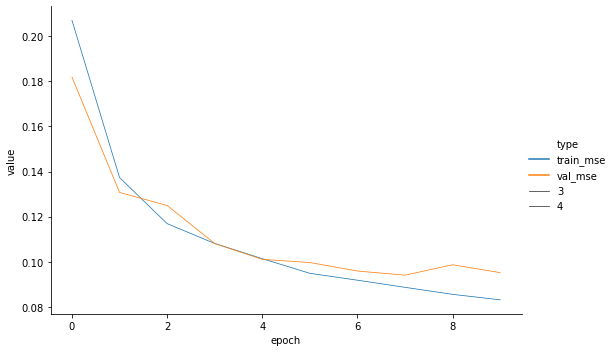

In [91]:
g = sns.relplot(x='epoch', y='value', hue='type', kind='line', data=h, aspect=1.5, size=4)
# g.ax.set_ylim(0, 2)

## Check predictions

In [94]:
y_pred = nvidia.predict(valid)

[]

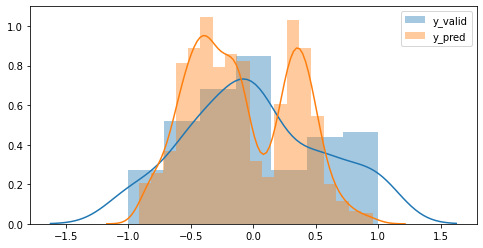

In [107]:
# Histogram of output distribution
fig, ax = plt.subplots(figsize=(8, 4))
g = sns.distplot(y_valid, label='y_valid', ax=ax)
sns.distplot(y_pred, label='y_pred', ax=ax)
plt.legend()
plt.plot()

Better than the original ResNet + Dense model.

In [97]:
valid_batch = next(iter(valid))
pred_on_batch = nvidia.predict(valid_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean steering: 0.3074810677407616
Model steering: -0.789431631565094
Original steering: -0.7


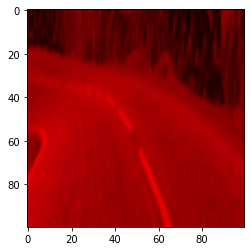

In [105]:
X_valid, y_valid = valid_batch[0].numpy(), valid_batch[1].numpy()

random_record = random.randint(0, batch_size - 1)
plt.imshow(X_valid[random_record])
print(f'Mean steering: {mean_steering}')
print(f'Model steering: {np.squeeze(pred_on_batch[random_record])}')
print(f'Original steering: {y_valid[random_record]}')

Much improvement from the ResNet model, can work with this for now.